# Aula 21 - Ensemble & Random Forest


## 1. O que é um ensemble?

![#trabalho em equipe funciona!](https://thumbs.gfycat.com/SlimyTepidAtlanticridleyturtle-size_restricted.gif)

<p style="text-align: center;"> #teamwork </p>



Junção de vários modelos, geralmente mais fracos, que juntos geram um melhor preditor. Basicamente segue a ideia de que várias "cabeças" pensam melhor do que uma.

### Vamos ver se isso é verdade mesmo!

In [1]:
## imports necessarios

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
import matplotlib.pyplot as plt
%matplotlib inline


Criaremos um modelo para predizer pessoas que devem procurar tratamento para saúde mental em empresas de tecnologia.

Vamos ler os dados e analisar o dataset:

In [2]:
df = pd.read_csv('survey.csv')

> Dataset retirado do [kaggle](https://www.kaggle.com/osmi/mental-health-in-tech-survey/kernels), porém foram filtrados apenas os países Canada, United Kingdom e United States para facilitar a análise

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1008 entries, 0 to 1007
Data columns (total 27 columns):
Timestamp                    1008 non-null object
Age                          1008 non-null int64
Gender                       1008 non-null object
Country                      1008 non-null object
state                        740 non-null object
self_employed                991 non-null object
family_history               1008 non-null object
treatment                    1008 non-null object
work_interfere               811 non-null object
no_employees                 1008 non-null object
remote_work                  1008 non-null object
tech_company                 1008 non-null object
benefits                     1008 non-null object
care_options                 1008 non-null object
wellness_program             1008 non-null object
seek_help                    1008 non-null object
anonymity                    1008 non-null object
leave                        1008 non-null obje

In [4]:
df.head()

,Timestamp,Age,Gender,Country,state,self_employed,family_history,treatment,work_interfere,no_employees,...,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,comments
0,2014-08-27 11:29:31,37,Female,United States,IL,NaN,No,Yes,Often,6-25,...,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,No,NaN
1,2014-08-27 11:29:37,44,M,United States,IN,NaN,No,No,Rarely,More than 1000,...,Don't know,Maybe,No,No,No,No,No,Don't know,No,NaN
2,2014-08-27 11:29:44,32,Male,Canada,NaN,NaN,No,No,Rarely,6-25,...,Somewhat difficult,No,No,Yes,Yes,Yes,Yes,No,No,NaN
3,2014-08-27 11:29:46,31,Male,United Kingdom,NaN,NaN,Yes,Yes,Often,26-100,...,Somewhat difficult,Yes,Yes,Some of them,No,Maybe,Maybe,No,Yes,NaN
4,2014-08-27 11:30:22,31,Male,United States,TX,NaN,No,No,Never,100-500,...,Don't know,No,No,Some of them,Yes,Yes,Yes,Don't know,No,NaN


Vemos várias variáveis como objetos e vários *NaN*s, vamos tratá-los.



In [5]:
# Timestamp:
del df['Timestamp']

### Variáveis com NaN:



In [6]:
# comments:
df.loc[df['comments'].notnull(), 'comments'].head()

12    I'm not on my company's health insurance which...
14    I have chronic low-level neurological issues t...
15    My company does provide healthcare but not to ...
22                  Relatively new job. Ask again later
23    Sometimes I think  about using drugs for my me...
Name: comments, dtype: object

Nao aprendemos NLP... ainda

In [7]:
del df['comments']

work_interfere:

In [8]:
df['work_interfere'].value_counts()

Sometimes    389
Never        173
Rarely       139
Often        110
Name: work_interfere, dtype: int64

In [9]:
df['work_interfere'].fillna('DontKnow', inplace=True)

self_employed:

In [10]:
df['self_employed'].value_counts()

No     896
Yes     95
Name: self_employed, dtype: int64

In [11]:
df['self_employed'].fillna('No', inplace=True)

In [12]:
df['state'].value_counts()

CA    138
WA     70
NY     56
TN     45
TX     44
OH     30
OR     29
PA     29
IL     28
IN     27
MI     22
MN     21
MA     20
FL     15
NC     14
VA     14
MO     12
WI     12
GA     12
UT     10
CO      9
AL      8
MD      7
AZ      7
OK      6
NJ      6
SC      5
KY      5
IA      4
DC      4
CT      4
SD      3
KS      3
VT      3
NV      3
NH      3
NM      2
NE      2
WY      2
WV      1
MS      1
RI      1
ME      1
LA      1
ID      1
Name: state, dtype: int64

In [13]:
del df['state']

### Variaveis categoricas

Gender:

In [14]:
df['Gender'].unique()

array(['Female', 'M', 'Male', 'female', 'male', 'm', 'Male-ish', 'maile',
       'Trans-female', 'Cis Female', 'F', 'Cis Male', 'Woman', 'f',
       'Male (CIS)', 'queer/she/they', 'non-binary', 'Femake', 'woman',
       'Make', 'Nah', 'Enby', 'Genderqueer', 'Female ', 'Androgyne',
       'Agender', 'cis-female/femme', 'Guy (-ish) ^_^',
       'male leaning androgynous', 'Male ', 'Man', 'Trans woman', 'msle',
       'Neuter', 'Female (trans)', 'Female (cis)', 'Mail', 'cis male',
       'p', 'femail', 'Cis Man',
       'ostensibly male, unsure what that really means'], dtype=object)

Vemos muitas categorias aqui, vamos tratar:

In [15]:
male_str = ["male", "m", "male-ish", "maile", "mal", "male (cis)", "make", "male ", "man","msle", "mail", "malr","cis man", "Cis Male", "cis male"]
trans_str = ["trans-female", "something kinda male?", "queer/she/they", "non-binary","nah", "all", "enby", "fluid", "genderqueer", "androgyne", "agender", "male leaning androgynous", "guy (-ish) ^_^", "trans woman", "neuter", "female (trans)", "queer", "ostensibly male, unsure what that really means"]           
female_str = ["cis female", "f", "female", "woman",  "femake", "female ","cis-female/femme", "female (cis)", "femail"]

for (row, col) in df.iterrows():

    if str.lower(col.Gender) in male_str:
        df['Gender'].replace(to_replace=col.Gender, value='male', inplace=True)

    if str.lower(col.Gender) in female_str:
        df['Gender'].replace(to_replace=col.Gender, value='female', inplace=True)

    if str.lower(col.Gender) in trans_str:
        df['Gender'].replace(to_replace=col.Gender, value='trans', inplace=True)

In [16]:
df['Gender'].value_counts()

male      772
female    220
trans      15
p           1
Name: Gender, dtype: int64

In [17]:
df = df[df['Gender']!='p']

In [18]:
df['Gender'].unique()

array(['female', 'male', 'trans'], dtype=object)

Vamos ver quantos países temos:

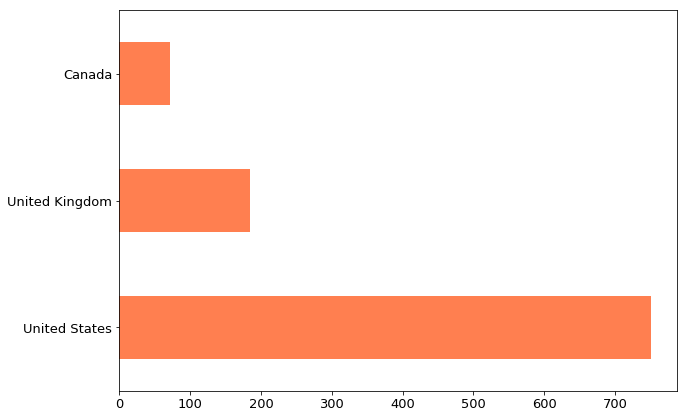

In [19]:
df['Country'].value_counts().plot(kind='barh', figsize=(10,7),
                                        color="coral", fontsize=13)

Vamos criar as dummies

In [20]:
df = pd.get_dummies(df, columns=['Gender', 'Country', 'self_employed', 'family_history', 'treatment', 'work_interfere',
                 'no_employees', 'remote_work', 'tech_company', 'anonymity', 'leave', 'mental_health_consequence',
                 'phys_health_consequence', 'coworkers', 'supervisor', 'mental_health_interview', 'phys_health_interview',
                 'mental_vs_physical', 'obs_consequence', 'benefits', 'care_options', 'wellness_program',
                 'seek_help'])

In [21]:
df.shape

(1007, 71)

In [22]:
df.columns.values

array(['Age', 'Gender_female', 'Gender_male', 'Gender_trans',
       'Country_Canada', 'Country_United Kingdom',
       'Country_United States', 'self_employed_No', 'self_employed_Yes',
       'family_history_No', 'family_history_Yes', 'treatment_No',
       'treatment_Yes', 'work_interfere_DontKnow', 'work_interfere_Never',
       'work_interfere_Often', 'work_interfere_Rarely',
       'work_interfere_Sometimes', 'no_employees_1-5',
       'no_employees_100-500', 'no_employees_26-100',
       'no_employees_500-1000', 'no_employees_6-25',
       'no_employees_More than 1000', 'remote_work_No', 'remote_work_Yes',
       'tech_company_No', 'tech_company_Yes', "anonymity_Don't know",
       'anonymity_No', 'anonymity_Yes', "leave_Don't know",
       'leave_Somewhat difficult', 'leave_Somewhat easy',
       'leave_Very difficult', 'leave_Very easy',
       'mental_health_consequence_Maybe', 'mental_health_consequence_No',
       'mental_health_consequence_Yes', 'phys_health_consequence_May

In [23]:
df.drop(columns=['family_history_No', 'treatment_No', 'remote_work_No', 'tech_company_No'], inplace=True)

Vamos dar uma olhada na distribuićão da variável resposta:

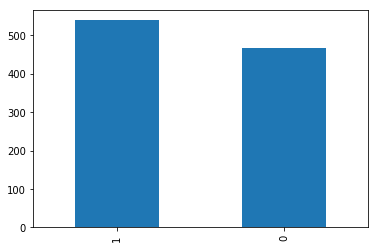

In [24]:
df['treatment_Yes'].value_counts().plot(kind='bar')

## Finalmente, vamos ao treinamento!

Vamos separar os dados em treino e teste:

In [25]:
X = df.drop('treatment_Yes', axis=1)
y = df['treatment_Yes']

X_train, X_test, y_train, y_test = train_test_split(X , y, test_size = 0.15, random_state=0)
print(X_train.shape)

(855, 66)


 Vamos usar os dois métodos mais dummies que aprendemos até agora para tentar predizer 

## Relembrando Árvores de Decisão:

<img src="https://annalyzin.files.wordpress.com/2016/07/decision-trees-titanic-tutorial.png" alt="drawing" style="width:500px;"/>
<p style="text-align: center;"> Exemplo de árvore de decisão para classificar sobreviventes do Titanic </p>

In [26]:
# crie o modelo com random state igual a 10
model_tree = DecisionTreeClassifier(random_state=10)
model_tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=10,
            splitter='best')

In [27]:
y_pred_tree_train = model_tree.predict_proba(X_train)
print("Acurácia: {:.2f}".format(accuracy_score(y_train, y_pred_tree_train[:,1]>0.5)))
print("Precisão: {:.2f}".format(precision_score(y_train, y_pred_tree_train[:,1]>0.5)))
print("Sensibilidade: {:.2f}".format(recall_score(y_train, y_pred_tree_train[:,1]>0.5)))

Acurácia: 1.00
Precisão: 1.00
Sensibilidade: 1.00


In [28]:
y_pred_tree = model_tree.predict_proba(X_test)
print("Acurácia: {:.2f}".format(accuracy_score(y_test, y_pred_tree[:,1]>0.5)))
print("Precisão: {:.2f}".format(precision_score(y_test, y_pred_tree[:,1]>0.5)))
print("Sensibilidade: {:.2f}".format(recall_score(y_test, y_pred_tree[:,1]>0.5)))


Acurácia: 0.81
Precisão: 0.85
Sensibilidade: 0.80


## KNN 

![#knn!](https://importq.files.wordpress.com/2017/11/knn_neigh.gif?w=656)

 - algoritmo de abordagem "preguiçosa"
 - assume que elementos similares estão em proximidade
 - Calcula a distância para os *N* vizinhos mais próximos e determina a classe de acordo com a classe dos vizinhos
 
Mais informações: https://www.analyticsvidhya.com/blog/2018/03/introduction-k-neighbours-algorithm-clustering/

In [29]:
# crie o modelo com random state igual a 10
model_knn = KNeighborsClassifier()
model_knn.fit(X_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [30]:
y_pred_knn_train = model_knn.predict_proba(X_train)
print("Acurácia: {:.2f}".format(accuracy_score(y_train, y_pred_knn_train[:,1]>0.5)))
print("Precisão: {:.2f}".format(precision_score(y_train, y_pred_knn_train[:,1]>0.5)))
print("Sensibilidade: {:.2f}".format(recall_score(y_train, y_pred_knn_train[:,1]>0.5)))

Acurácia: 0.78
Precisão: 0.81
Sensibilidade: 0.76


In [31]:
y_pred_knn = model_knn.predict_proba(X_test)
print("Acurácia: {:.2f}".format(accuracy_score(y_test, y_pred_knn[:,1]>0.5)))
print("Precisão: {:.2f}".format(precision_score(y_test, y_pred_knn[:,1]>0.5)))
print("Sensibilidade: {:.2f}".format(recall_score(y_test, y_pred_knn[:,1]>0.5)))

Acurácia: 0.69
Precisão: 0.71
Sensibilidade: 0.72


### Como acham que podemos combinar esses modelos?
- Fazendo votação das predições
- Fazendo média das predições
- Usando as predições como entrada para uma segunda camada de modelos

In [32]:
model_vot = VotingClassifier(estimators=[('tree', model_tree), ('knn', model_knn)], voting='soft')
model_vot.fit(X_train, y_train)                             

VotingClassifier(estimators=[('tree', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_le...ki',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'))],
         flatten_transform=None, n_jobs=None, voting='soft', weights=None)

In [33]:
y_pred = model_vot.predict(X_test)
print("Acurácia: {:.2f}".format(accuracy_score(y_test, y_pred)))
print("Precisão: {:.2f}".format(precision_score(y_test, y_pred)))
print("Sensibilidade: {:.2f}".format(recall_score(y_test, y_pred)))

Acurácia: 0.82
Precisão: 0.87
Sensibilidade: 0.80


In [34]:
x_novo = np.array([y_pred_tree_train[:,1], y_pred_knn_train[:,1]])
x_novo = x_novo.transpose()

x_novo_test = np.array([y_pred_tree[:,1], y_pred_knn[:,1]])
x_novo_test = x_novo_test.transpose()

In [35]:
model_lr2 = LogisticRegression()
model_lr2.fit(x_novo, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [36]:
y_pred_lr = model_lr2.predict_proba(x_novo_test)
print("Acurácia: {:.2f}".format(accuracy_score(y_test, y_pred_lr[:,1]>0.5)))
print("Precisão: {:.2f}".format(precision_score(y_test, y_pred_lr[:,1]>0.5)))
print("Sensibilidade: {:.2f}".format(recall_score(y_test, y_pred_lr[:,1]>0.5)))

Acurácia: 0.81
Precisão: 0.85
Sensibilidade: 0.80


## 2. Tipos de Ensemble:

Existem vários formas diferentes de combinar os modelos. As principais são:


### **1. Voting Based Classifier:**

**1. a) Majority Vote**

A ideia é fazer uma votação entre as predições dos modelos. A classe que tiver mais votos vence. Também podemos ter uma variação desse algoritmo, o **Weighted Voting Classifier**, em que na votação alguns modelos tem mais peso que outros.

![](voting.png)


**1. b) Average Classifier:**

A ideia é similar ao anterior, porém ao invés de uma votação é calculada a média das predições. Da mesma forma podemos ter alguns modelos com mais peso que outros tendo um **Weighted Average Classifier**
![](average.png)


### 2. Stacking:

Nesse modelo as predições dos modelos anteriores são combinadas por um outro modelo para obter a saída final. Podem ser criadas várias camadas com modelos diferentes.

![](stacking.png)

### 3. Boosting:

Os modelos são treinados com os mesmos datasets, porém os pesos das intâncias são ajustados de acordo com o erro das predições anteriores. Veram mais na próxima aula...

![](boosting.png)

## 4. BAGGING: 
Todos os modelos deste tipo de ensemble são do **mesmo algoritmo**, porém os dados de entrada de cada um são amostras do dado original, com a **mesma quantidade de dados do dataset original**, selecionadas usando o método bootstrap (**aleatória com repetição**). 

**AQUI TEMOS A RANDOM FOREST**

![](bagging.png)

## 4. RANDOM FOREST

###  Como Funciona?

![#OOB!](https://cdn-images-1.medium.com/max/1600/1*yoW30XVqAnKOA-7AArXqNg.gif)

- Algoritmo de bagging que usa árvores de decisão
- Cada árvore terá um conjunto diferente de dados e de features
- Out-of-bag score: os dados que não foram usados naquela árvore são utilizados como teste

In [37]:
model = RandomForestClassifier(n_estimators=10, random_state=0, oob_score=True)
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=True, random_state=0, verbose=0, warm_start=False)

In [38]:
model.oob_score_

0.7543859649122807

In [39]:
y_pred = model.predict(X_test)
print("Acurácia: {:.2f}".format(accuracy_score(y_test, y_pred)))
print("Precisão: {:.2f}".format(precision_score(y_test, y_pred)))
print("Sensibilidade: {:.2f}".format(recall_score(y_test, y_pred)))

Acurácia: 0.86
Precisão: 0.85
Sensibilidade: 0.89


Vamos testar outras combinações de parâmetros?

`Dica 1: Manter o mesmo random_state para comparação de resultados
 Dica 2: Os parâmetros são similares as árvores de decisão
 Dica 3: Número de estimadores e de features são os mais relevantes ` 

In [40]:
model = RandomForestClassifier(n_estimators=20, random_state=0, oob_score=True)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("OOB Score: {:.2f}".format(model.oob_score_))
print("Acurácia: {:.2f}".format(accuracy_score(y_test, y_pred)))
print("Precisão: {:.2f}".format(precision_score(y_test, y_pred)))
print("Sensibilidade: {:.2f}".format(recall_score(y_test, y_pred)))

OOB Score: 0.80
Acurácia: 0.88
Precisão: 0.87
Sensibilidade: 0.93


In [41]:
model = RandomForestClassifier(n_estimators=40, random_state=0, oob_score=True)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("OOB Score: {:.2f}".format(model.oob_score_))
print("Acurácia: {:.2f}".format(accuracy_score(y_test, y_pred)))
print("Precisão: {:.2f}".format(precision_score(y_test, y_pred)))
print("Sensibilidade: {:.2f}".format(recall_score(y_test, y_pred)))

OOB Score: 0.82
Acurácia: 0.89
Precisão: 0.88
Sensibilidade: 0.93


In [42]:
model = RandomForestClassifier(n_estimators=50, random_state=0, oob_score=True)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("OOB Score: {:.2f}".format(model.oob_score_))
print("Acurácia: {:.2f}".format(accuracy_score(y_test, y_pred)))
print("Precisão: {:.2f}".format(precision_score(y_test, y_pred)))
print("Sensibilidade: {:.2f}".format(recall_score(y_test, y_pred)))

OOB Score: 0.82
Acurácia: 0.89
Precisão: 0.88
Sensibilidade: 0.94


In [83]:
model = RandomForestClassifier(n_estimators=50, random_state=0, oob_score=True, max_features=7)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("OOB Score: {:.2f}".format(model.oob_score_))
print("Acurácia: {:.2f}".format(accuracy_score(y_test, y_pred)))
print("Precisão: {:.2f}".format(precision_score(y_test, y_pred)))
print("Sensibilidade: {:.2f}".format(recall_score(y_test, y_pred)))

OOB Score: 0.81
Acurácia: 0.91
Precisão: 0.90
Sensibilidade: 0.95


Feature importance:

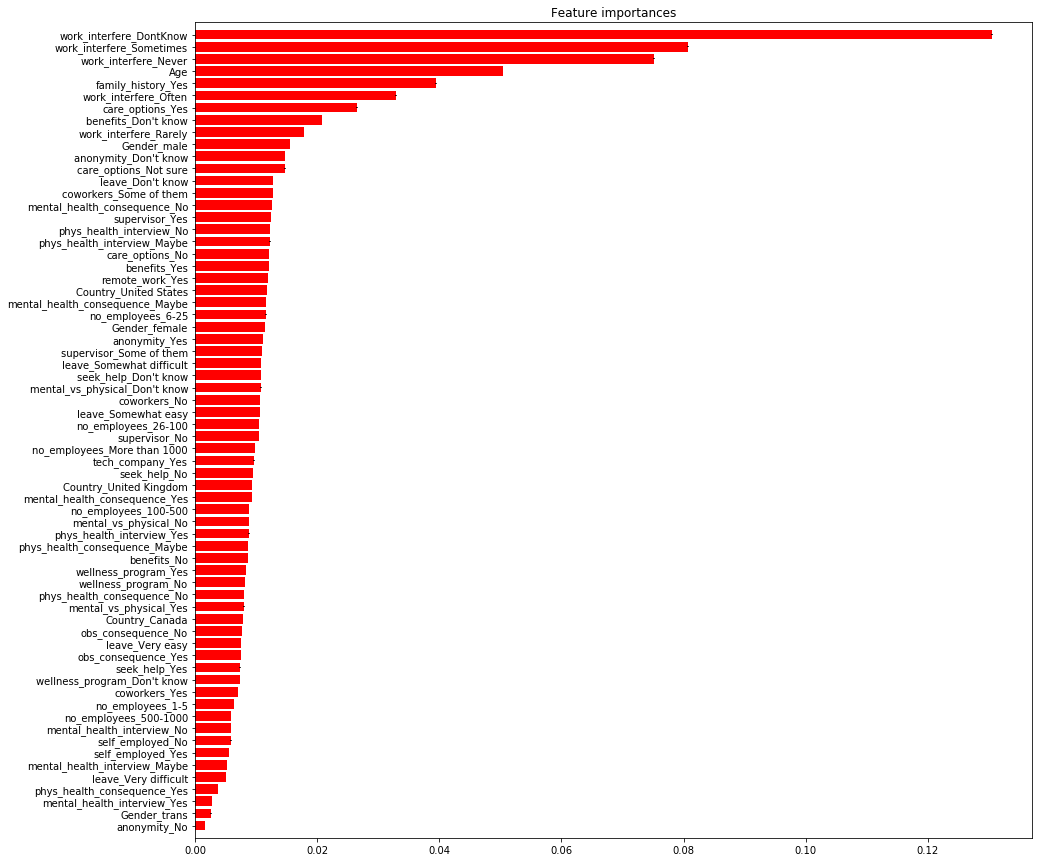

In [44]:
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_],
             axis=0)
indices = np.argsort(importances)[::1]


# Plot the feature importances of the forest
plt.figure(figsize=(15,15))
plt.title("Feature importances")
plt.barh(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.yticks(range(X.shape[1]), X.columns[indices])
plt.ylim([-1, X.shape[1]])
plt.show()

In [45]:
from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(model.estimators_[0], out_file='tree.dot', 
                feature_names = X.columns,
                class_names = ['1', '0'],
                rounded = True, proportion = False, 
                precision = 2, filled = True, max_depth=4)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')

### Quais tipos de problemas podemos resolver com random forest?

- Tanto regressão quanto classificação
- Problemas variados de negócios, ex: churn, predição de vendas, etc.
- Basicamente **quase** todos os problemas
- Ruim para trends (tendências) e problemas com dados em que haverão muitos dados não vistos no treinamento

### Quais vantagens e desvantagens vocês enxergam?

*. Vantagens:
- Tanto regressão quanto classificação
- Pouca parametrização
- Não causa overfitting
- Média interpretabilidade 
- Também pode ser usada para tratar missing-values e análise de grupos (clusters)

*. Desvantagens:
- Quanto mais árvores maior o tempo de **predição** e **gasto de memória**

## Desafios legais para serem resolvidos com RF:
- https://www.kaggle.com/c/sf-crime
- https://www.kaggle.com/c/house-prices-advanced-regression-techniques

# 5. LightGBM (Gradient Boosting Machine)


![](https://image.slidesharecdn.com/stratauk17salvarisfierrofastretraining-170523090635/95/speeding-up-machinelearning-applications-with-the-lightgbm-library-6-638.jpg)

In [156]:
import lightgbm as lgb

In [168]:
model = lgb.LGBMClassifier(objective = 'binary',
          n_jobs = 3, # Updated from 'nthread'
          silent = True,
          max_depth = 10,
          min_child_samples=5,
          learning_rate=0.1,
          n_estimators=50,
          num_leaves= 8)


model.fit(X_train, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=10,
        min_child_samples=5, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=50, n_jobs=3, num_leaves=8, objective='binary',
        random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [169]:
y_pred = model.predict(X_test)

print("Acurácia: {:.2f}".format(accuracy_score(y_test, y_pred)))
print("Precisão: {:.2f}".format(precision_score(y_test, y_pred)))
print("Sensibilidade: {:.2f}".format(recall_score(y_test, y_pred)))

Acurácia: 0.92
Precisão: 0.89
Sensibilidade: 0.98


### Quais vantagens e desvantagens vocês enxergam?
*. Vantagens:
- Tanto regressão quanto classificação
- Tem alta performance
- Funciona bem com datasets muito grandes


*. Desvantagens:
- É mais propenso a overfitting, por isso não funciona bem com poucos dados

## Desafios legais para serem resolvidos com ensemble:
- https://www.kaggle.com/c/avito-demand-prediction/data
- https://www.kaggle.com/c/recruit-restaurant-visitor-forecasting
- https://www.kaggle.com/c/sf-crime
- https://www.kaggle.com/c/house-prices-advanced-regression-techniques